In [1]:
from net_t2l import NetT2L

net = NetT2L()

/Users/kitt/miniconda3/envs/net/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at /Users/kitt/.cache/torch/sentence_transformers/fav-kky_FERNET-C5 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are in

Required knowledge initialized: n = 768, m = 6, pt = 0, pk = 60, labels: {0: 'KALENDÁŘ', 1: 'POKYN', 2: 'POZDRAV', 3: 'POZNEJ', 4: 'STOP', 5: 'VYGOOGLI'}


In [3]:
from time import time

def now():
    return round(time()-t0, 2)

def shot(step, phase, t=None, **dialog):
    print('D:',dialog)
    loss, acc, wrongs, oks = net.evaluate(ret_wrongs=True, ret_oks=True)
    exp[t if t == 0 else now()] = {
        'step': step,
        'phase': phase,
        'm': net.data.m,
        'pt': {label:net.data.data['train']['labels'].count(label) for label in net.data.labels},
        'loss': loss,
        'acc': acc,
        'wrongs': wrongs,
        'oks': oks,
        'dialog': dialog
    }

print('== Training loop ==')
exp = {}
steps = 100
t0 = time()

shot(step=0, phase='init', t=0)

for step in range(1, steps+1):
    ans = ''
    correction = ''
    prompt = input('\n\n> ')
    if prompt == 'done':
        break

    shot(step=step, phase='prompted', prompt=prompt)

    ans = net.predict(prompt)

    shot(step=step, phase='answered', prompt=prompt, ans=ans)

    correction = input(f'>> Ans: {ans} / Correct class (blank if OK): ')

    shot(step=step, phase='feedbacked', prompt=prompt, ans=ans, correction=correction)

    if correction:
        net.learn(sample=prompt, label=correction, verbose=False)
        shot(step=step, phase='retrained', prompt=prompt, ans=ans, correction=correction)
    else:
        if prompt not in net.data.data['train']['samples']:
            net.learn(sample=prompt, label=ans, verbose=False)
            shot(step=step, phase='tuned', prompt=prompt, ans=ans, correction=correction)
        else:
            shot(step=step, phase='passed', prompt=prompt, ans=ans, correction=correction)

    loss, acc = net.evaluate()
    print(f'== Acc: {acc}, Loss: {loss}')

== Training loop ==
D: {}
D: {'prompt': 'Ahoj'}
D: {'prompt': 'Ahoj', 'ans': 'POKYN'}
D: {'prompt': 'Ahoj', 'ans': 'POKYN', 'correction': 'POZDRAV'}
Sample Ahoj added to train. pt = 1
Final train loss: 0.0453268326818943, dev loss: 4.112004637718201
D: {'prompt': 'Ahoj', 'ans': 'POKYN', 'correction': 'POZDRAV'}
== Acc: 0.16666666666666666, Loss: 4.083752514297763
D: {'prompt': 'Zatoč doprava'}
D: {'prompt': 'Zatoč doprava', 'ans': 'POZDRAV'}
D: {'prompt': 'Zatoč doprava', 'ans': 'POZDRAV', 'correction': 'POKYN'}
Sample Zatoč doprava added to train. pt = 2
Sample Zatoč doprava added to dev.
Final train loss: 0.3851338028907776, dev loss: 3.286020517349243
D: {'prompt': 'Zatoč doprava', 'ans': 'POZDRAV', 'correction': 'POKYN'}
== Acc: 0.31666666666666665, Loss: 3.3159671823183694
D: {'prompt': 'Dobrý den'}
D: {'prompt': 'Dobrý den', 'ans': 'POZDRAV'}
D: {'prompt': 'Dobrý den', 'ans': 'POZDRAV', 'correction': ''}
Sample Dobrý den added to train. pt = 3
Final train loss: 0.1595715582370758

In [4]:
for t, val in exp.items():
    print(f'== [t={round(t, 2)}] Acc = {val["acc"]}, OKs: ({len(val["oks"])})')
    for ok in val['oks']:
        print(ok)

for w in exp[max(list(exp.keys()))]['wrongs']:
    print(w)

== [t=0] Acc = 0.16666666666666666, OKs: (10)
('Zablikej', 'POKYN')
('Zatoč', 'POKYN')
('Jdi vpřed', 'POKYN')
('Zapískej', 'POKYN')
('Zvedni pravou ruku', 'POKYN')
('Zvedni levou ruku', 'POKYN')
('Rozsviť LED', 'POKYN')
('Rozjeď se', 'POKYN')
('Otoč se', 'POKYN')
('Zamávej', 'POKYN')
== [t=2.51] Acc = 0.16666666666666666, OKs: (10)
('Zablikej', 'POKYN')
('Rozsviť LED', 'POKYN')
('Jdi vpřed', 'POKYN')
('Zamávej', 'POKYN')
('Rozjeď se', 'POKYN')
('Zvedni pravou ruku', 'POKYN')
('Otoč se', 'POKYN')
('Zapískej', 'POKYN')
('Zatoč', 'POKYN')
('Zvedni levou ruku', 'POKYN')
== [t=2.58] Acc = 0.16666666666666666, OKs: (10)
('Zatoč', 'POKYN')
('Zablikej', 'POKYN')
('Zvedni levou ruku', 'POKYN')
('Rozsviť LED', 'POKYN')
('Otoč se', 'POKYN')
('Jdi vpřed', 'POKYN')
('Zapískej', 'POKYN')
('Rozjeď se', 'POKYN')
('Zvedni pravou ruku', 'POKYN')
('Zamávej', 'POKYN')
== [t=4.69] Acc = 0.16666666666666666, OKs: (10)
('Zvedni levou ruku', 'POKYN')
('Rozsviť LED', 'POKYN')
('Zamávej', 'POKYN')
('Zvedni prav

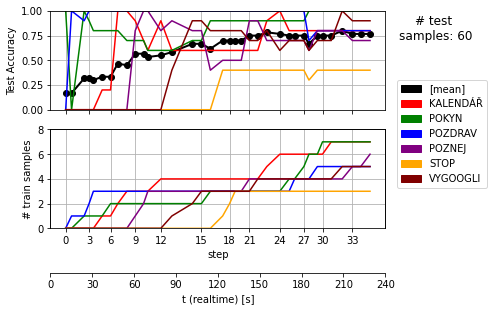

In [6]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

labels = net.data.labels
COLORS = ['red', 'green', 'blue', 'purple', 'orange', 'maroon', 'yellow', 'cyan', 'brown', 'pink']
lab2COL = {label:col for label, col in zip(labels, COLORS)}

fig, ax = plt.subplots(2, 1, sharex = True)

# Taking the states at the end of each iteration
ts = sorted([key for key, val in exp.items() if val['step'] == 0 or val['phase'] in ('tuned', 'passed', 'retrained')])
steps = [exp[t]['step'] for t in ts]

# == AX0: Acc
ax[0].plot(ts, [exp[t]['acc'] for t in ts], 'ko-', linewidth='2')

for label in labels:
    acc_ = []
    for t in ts:
        
        wr = len([w for w in exp[t]['wrongs'] if w[1] == label])
        ok = len([o for o in exp[t]['oks'] if o[1] == label])
        acc_.append(ok/(ok+wr))

    ax[0].plot(ts, acc_, '-', color=lab2COL[label])

ax[0].set_title(f'# test \nsamples: {net.data.pk}', y=0.65, x=1.15)
ax[0].set_ylim([0, 1])
ax[0].set_ylabel('Test Accuracy')
ax[0].grid()

# == AX1: Samples
for label in labels:
    ax[1].plot(ts, [exp[t]['pt'][label] for t in ts], '-', color=lab2COL[label])

#w = 0.2
#for t, step in zip(ts, steps):
#    if step % 1 == 0:
#        for li, label in enumerate(labels):
#            ax[1].bar(t-w*(len(labels)/2)+(w*li), exp[t]['pt'][label], width=w, color=lab2COL[label])

#ax[1].plot(steps, [net.data.pk]*len(steps), '--', color='darkgreen', linewidth='2')

ax[1].set_ylabel('# train samples')
ax[1].set_ylim([0, 8])
ax[1].set_xlabel('step')
ax[1].set_xticks([t for i, t in enumerate(ts) if i%3 == 0])
ax[1].set_xticklabels([s for i, s in enumerate(steps) if i%3 == 0])

ax[1].legend(
    bbox_to_anchor=(1.02, 1.55),
    handles=[mpatches.Patch(color='black', label='[mean]')]+[mpatches.Patch(color=lab2COL[label], label=label) for label in labels])

ax[1].grid()
axt = ax[1].twiny()
axt.set_xlabel('t (realtime) [s]')
ticklabels = [t for t in range(int(ts[-1])) if t % 30 == 0]
axt.set_xticks(ticklabels)
axt.set_xticklabels(ticklabels)

# Move twinned axis ticks and label from top to bottom
axt.xaxis.set_ticks_position("bottom")
axt.xaxis.set_label_position("bottom")

# Offset the twin axis below the host
axt.spines["bottom"].set_position(("axes", -0.45))

plt.show()